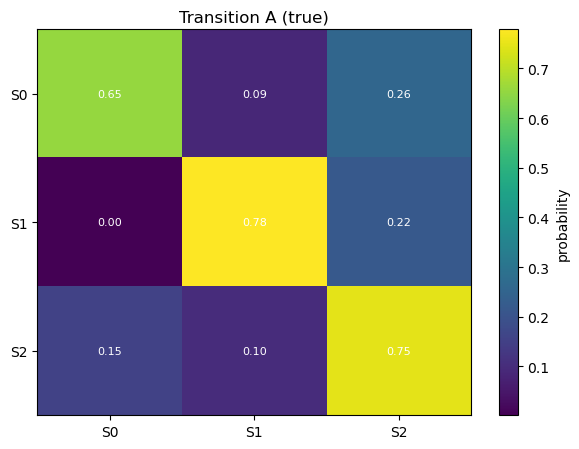

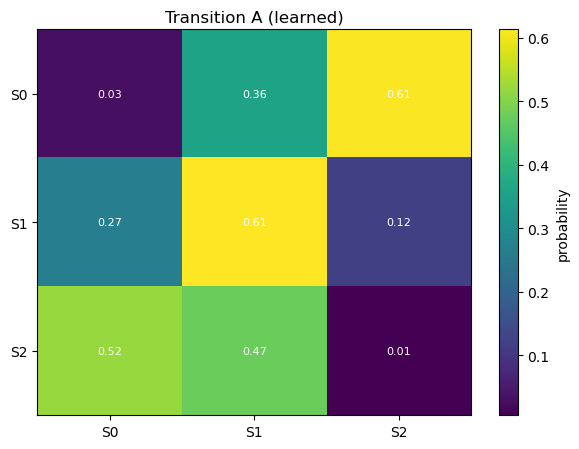

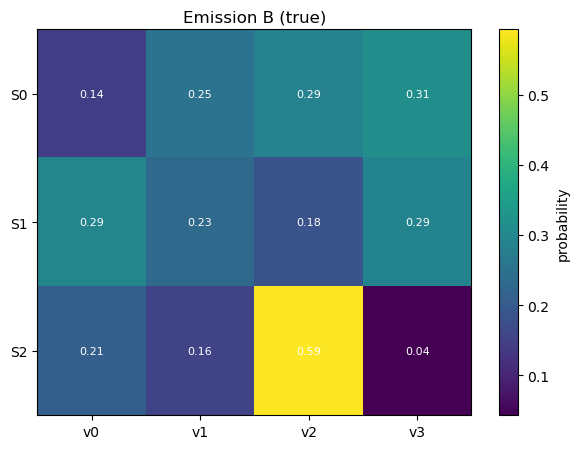

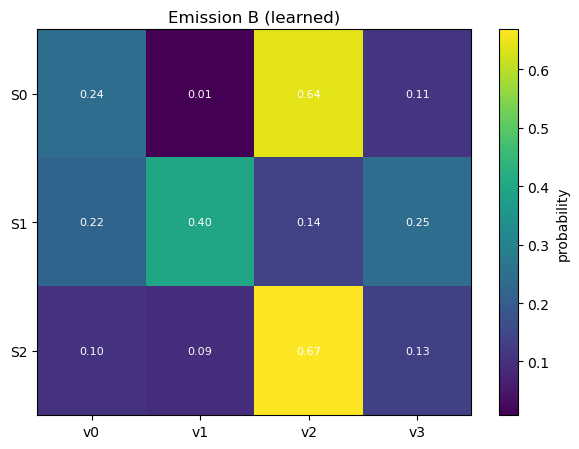

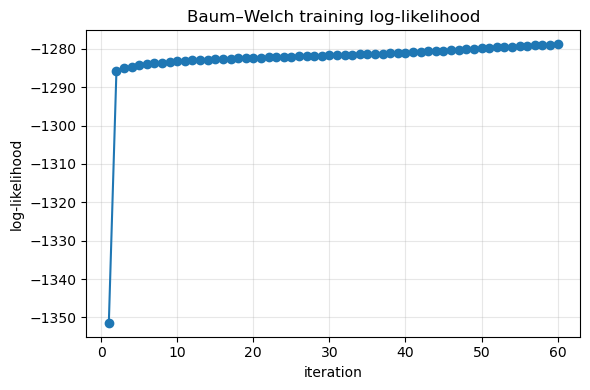

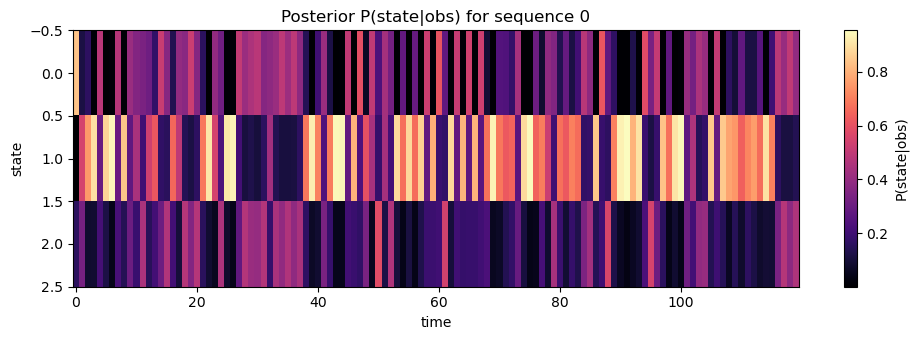

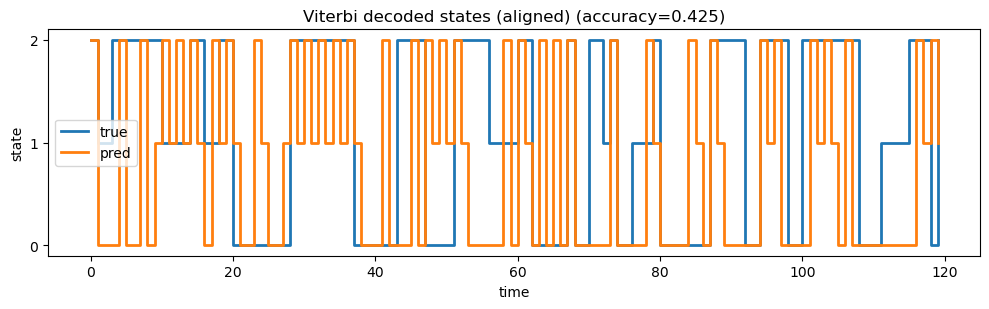

Training finished.
Iterations: 60 | Final log-likelihood: -1278.801
Sequence 0 Viterbi accuracy (after label alignment): 0.425


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import permutations
from typing import List, Tuple, Dict, Optional

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.bbox"] = "tight"


def normalize_rows(M: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    M = np.asarray(M, dtype=float)
    s = M.sum(axis=1, keepdims=True)
    s[s == 0] = 1.0
    return M / (s + eps)

def normalize_vec(v: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    v = np.asarray(v, dtype=float)
    s = v.sum()
    return v / (s + eps)

def sample_discrete(p: np.ndarray, rng: np.random.Generator) -> int:
    return int(rng.choice(len(p), p=normalize_vec(p)))

def hmm_sample(pi: np.ndarray, A: np.ndarray, B: np.ndarray, T: int, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    
    K, M = B.shape
    z = np.zeros(T, dtype=int)
    o = np.zeros(T, dtype=int)
    z[0] = sample_discrete(pi, rng)
    o[0] = sample_discrete(B[z[0]], rng)
    for t in range(1, T):
        z[t] = sample_discrete(A[z[t-1]], rng)
        o[t] = sample_discrete(B[z[t]], rng)
    return z, o

def make_synthetic_hmm(K: int = 3, M: int = 4, rng: Optional[np.random.Generator] = None):
   
    rng = np.random.default_rng(7) if rng is None else rng
    pi_true = normalize_vec(rng.random(K))
    A_true = normalize_rows(rng.random((K, K)) + 2.0*np.eye(K))  # encourage persistence
    B_true = normalize_rows(rng.random((K, M)))
    return pi_true, A_true, B_true

def generate_dataset(pi: np.ndarray, A: np.ndarray, B: np.ndarray, n_seqs: int = 8, T: int = 120, seed: int = 123):
    rng = np.random.default_rng(seed)
    Z, O = [], []
    for _ in range(n_seqs):
        z, o = hmm_sample(pi, A, B, T, rng)
        Z.append(z)
        O.append(o)
    return Z, O


def forward_scaled(obs: np.ndarray, pi: np.ndarray, A: np.ndarray, B: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    obs: (T,) integers in [0..M-1]
    Returns: alpha (T,K) scaled, c (T,), loglik
    """
    T = len(obs)
    K = A.shape[0]
    alpha = np.zeros((T, K))
    c = np.zeros(T)

    # t = 0
    alpha[0] = pi * B[:, obs[0]]
    c[0] = alpha[0].sum()
    if c[0] == 0: c[0] = 1e-16
    alpha[0] /= c[0]

    # t >= 1
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, obs[t]]
        c[t] = alpha[t].sum()
        if c[t] == 0: c[t] = 1e-16
        alpha[t] /= c[t]

    loglik = np.sum(np.log(c + 1e-16))
    return alpha, c, loglik

def backward_scaled(obs: np.ndarray, A: np.ndarray, B: np.ndarray, c: np.ndarray) -> np.ndarray:
    """
    Returns beta (T,K) scaled consistently with forward_scaled.
    """
    T = len(obs)
    K = A.shape[0]
    beta = np.zeros((T, K))
    beta[T-1] = 1.0 / c[T-1]
    for t in reversed(range(T-1)):
        beta[t] = (A @ (B[:, obs[t+1]] * beta[t+1]))
        beta[t] /= c[t]
    return beta

def estep_gammas_xis(obs: np.ndarray, pi: np.ndarray, A: np.ndarray, B: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
    alpha, c, ll = forward_scaled(obs, pi, A, B)
    beta = backward_scaled(obs, A, B, c)
    gamma = alpha * beta
    gamma /= gamma.sum(axis=1, keepdims=True)

    T = len(obs)
    K = A.shape[0]
    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        denom = np.sum(alpha[t][:, None] * A * (B[:, obs[t+1]] * beta[t+1])[None, :]) + 1e-16
        xi[t] = (alpha[t][:, None] * A * (B[:, obs[t+1]] * beta[t+1])[None, :]) / denom
    return gamma, xi, ll


def baum_welch_train(seqs: List[np.ndarray], K: int, M: int, max_iter: int = 50, tol: float = 1e-4, seed: int = 0):
    rng = np.random.default_rng(seed)
    pi = normalize_vec(rng.random(K))
    A = normalize_rows(rng.random((K, K)))
    B = normalize_rows(rng.random((K, M)))

    prev_ll = -np.inf
    loglik_hist = []

    for it in range(1, max_iter + 1):
        pi_num = np.zeros(K)
        A_num = np.zeros((K, K))
        A_den = np.zeros(K)
        B_num = np.zeros((K, M))
        B_den = np.zeros(K)
        total_ll = 0.0

        for obs in seqs:
            gamma, xi, ll = estep_gammas_xis(obs, pi, A, B)
            total_ll += ll
            pi_num += gamma[0]
            A_num += xi.sum(axis=0)
            A_den += gamma[:-1].sum(axis=0)
            for v in range(M):
                mask = (obs == v)
                if np.any(mask):
                    B_num[:, v] += gamma[mask].sum(axis=0)
            B_den += gamma.sum(axis=0)

        pi = normalize_vec(pi_num)
        A = normalize_rows(A_num + 1e-12)  # smoothing
        B = normalize_rows(B_num + 1e-12)

        loglik_hist.append(total_ll)
        if it > 1 and abs(loglik_hist[-1] - loglik_hist[-2]) < tol:
            break

    return {"pi": pi, "A": A, "B": B, "loglik": np.array(loglik_hist)}

# --------------------------
# Viterbi decoding (log domain)
# --------------------------
def viterbi_decode(obs: np.ndarray, pi: np.ndarray, A: np.ndarray, B: np.ndarray) -> np.ndarray:
    T = len(obs); K = A.shape[0]
    logA = np.log(A + 1e-16); logB = np.log(B + 1e-16); logpi = np.log(pi + 1e-16)
    delta = np.zeros((T, K)) - np.inf
    psi = np.zeros((T, K), dtype=int)
    delta[0] = logpi + logB[:, obs[0]]
    for t in range(1, T):
        for j in range(K):
            vals = delta[t-1] + logA[:, j]
            psi[t, j] = np.argmax(vals)
            delta[t, j] = vals[psi[t, j]] + logB[j, obs[t]]
    zhat = np.zeros(T, dtype=int)
    zhat[T-1] = np.argmax(delta[T-1])
    for t in reversed(range(T-1)):
        zhat[t] = psi[t+1, zhat[t+1]]
    return zhat

# --------------------------
# Alignment helper (label symmetry)
# --------------------------
def best_label_permutation(true_states: np.ndarray, pred_states: np.ndarray, K: int) -> Tuple[np.ndarray, Dict[int, int]]:
    # Find permutation P that maximizes matches between P(pred) and true
    best_perm = None; best_acc = -1.0
    for perm in permutations(range(K)):
        mapped = np.array([perm[s] for s in pred_states])
        acc = (mapped == true_states).mean()
        if acc > best_acc:
            best_acc = acc; best_perm = np.array(perm)
    mapping = {k: best_perm[k] for k in range(K)}
    mapped_pred = np.array([mapping[s] for s in pred_states])
    return mapped_pred, mapping

# --------------------------
# Visualization utilities
# --------------------------
def heatmap(M: np.ndarray, title: str, xticks: List[str], yticks: List[str], fname: str):
    plt.figure(figsize=(6,4.6))
    plt.imshow(M, cmap="viridis", aspect="auto")
    plt.colorbar(label="probability")
    plt.xticks(range(len(xticks)), xticks)
    plt.yticks(range(len(yticks)), yticks)
    plt.title(title)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            plt.text(j, i, f"{M[i,j]:.2f}", ha="center", va="center", color="w", fontsize=8)
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def plot_loglik(ll_hist: np.ndarray, fname: str):
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(ll_hist)+1), ll_hist, marker="o")
    plt.xlabel("iteration")
    plt.ylabel("log-likelihood")
    plt.title("Baum–Welch training log-likelihood")
    plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def posterior_heatmap(gamma: np.ndarray, fname: str, title: str = "Posterior state probabilities"):
    plt.figure(figsize=(10, 3.5))
    plt.imshow(gamma.T, aspect="auto", cmap="magma")
    plt.colorbar(label="P(state|obs)")
    plt.xlabel("time")
    plt.ylabel("state")
    plt.title(title)
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def state_timeline(true_z: np.ndarray, pred_z: np.ndarray, fname: str, title: str):
    T = len(true_z)
    plt.figure(figsize=(10, 3.2))
    plt.step(range(T), true_z, where="post", label="true", lw=2)
    plt.step(range(T), pred_z, where="post", label="pred", lw=2)
    plt.yticks(sorted(np.unique(np.concatenate([true_z, pred_z]))))
    plt.xlabel("time"); plt.ylabel("state")
    plt.title(f"{title} (accuracy={np.mean(true_z==pred_z):.3f})")
    plt.legend()
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

# --------------------------
# End-to-end demo on synthetic data
# --------------------------
def run_demo(K: int = 3, M: int = 4, n_seqs: int = 8, T: int = 120, max_iter: int = 60, tol: float = 1e-4, scale_names: bool = True):
    # 1) Ground-truth HMM and data
    pi_true, A_true, B_true = make_synthetic_hmm(K=K, M=M)
    Z_true, O_obs = generate_dataset(pi_true, A_true, B_true, n_seqs=n_seqs, T=T)

    # 2) Train with Baum–Welch
    model = baum_welch_train([np.array(o, dtype=int) for o in O_obs], K=K, M=M, max_iter=max_iter, tol=tol, seed=0)
    pi_hat, A_hat, B_hat = model["pi"], model["A"], model["B"]
    ll_hist = model["loglik"]

    # 3) Decode a sequence with Viterbi and align labels for visualization
    seq_id = 0
    obs0 = np.array(O_obs[seq_id])
    z_true0 = np.array(Z_true[seq_id])
    z_vit0 = viterbi_decode(obs0, pi_hat, A_hat, B_hat)
    z_vit0_aligned, mapping = best_label_permutation(z_true0, z_vit0, K=K)

    # 4) Posteriors for one sequence
    gamma0, _, _ = estep_gammas_xis(obs0, pi_hat, A_hat, B_hat)

    # 5) Visualizations
    st_names = [f"S{i}" for i in range(K)]
    sym_names = [f"v{i}" for i in range(M)]
    heatmap(A_true, "Transition A (true)", st_names, st_names, "A_true.png")
    heatmap(A_hat, "Transition A (learned)", st_names, st_names, "A_learned.png")
    heatmap(B_true, "Emission B (true)", sym_names, st_names, "B_true.png")
    heatmap(B_hat, "Emission B (learned)", sym_names, st_names, "B_learned.png")
    plot_loglik(ll_hist, "loglik_training.png")
    posterior_heatmap(gamma0, "posterior_seq0.png", "Posterior P(state|obs) for sequence 0")
    state_timeline(z_true0, z_vit0_aligned, "viterbi_timeline_seq0.png", "Viterbi decoded states (aligned)")

    # 6) Save a labeled preview CSV (seq 0)
    df = pd.DataFrame({
        "t": np.arange(len(obs0)),
        "obs": obs0,
        "state_true": z_true0,
        "state_viterbi_aligned": z_vit0_aligned
    })
    df.to_csv("hmm_seq0_preview.csv", index=False)

    # Print concise summary
    acc0 = np.mean(z_true0 == z_vit0_aligned)
    print("Training finished.")
    print(f"Iterations: {len(ll_hist)} | Final log-likelihood: {ll_hist[-1]:.3f}")
    print(f"Sequence 0 Viterbi accuracy (after label alignment): {acc0:.3f}")
    return {
        "pi_true": pi_true, "A_true": A_true, "B_true": B_true,
        "pi_hat": pi_hat, "A_hat": A_hat, "B_hat": B_hat,
        "loglik_hist": ll_hist, "seq0_acc": acc0, "label_mapping": mapping
    }

# --------------------------
# Notebook/CLI-friendly entry
# --------------------------
def main(argv=None):
    import argparse
    parser = argparse.ArgumentParser(description="From-scratch HMM demo on synthetic discrete data")
    parser.add_argument("--states", type=int, default=3, help="number of hidden states")
    parser.add_argument("--symbols", type=int, default=4, help="number of discrete observation symbols")
    parser.add_argument("--nseqs", type=int, default=8, help="number of sequences")
    parser.add_argument("--T", type=int, default=120, help="sequence length")
    parser.add_argument("--max_iter", type=int, default=60, help="EM max iterations")
    parser.add_argument("--tol", type=float, default=1e-4, help="EM tolerance")
    if argv is None:
        args, _ = parser.parse_known_args()
    else:
        args, _ = parser.parse_known_args(argv)
    run_demo(K=args.states, M=args.symbols, n_seqs=args.nseqs, T=args.T, max_iter=args.max_iter, tol=args.tol)

if __name__ == "__main__":
    import sys
    # Notebook-safe invocation: ignore ipykernel flags
    if "ipykernel" in sys.modules:
        main([])
    else:
        main()
